In [1]:
# Parameters
TOKENIZER = "bert-base-cased"
LEARNING_RATE = 5e-05
BATCH_SIZE = 8
EPOCHS = 2


In [2]:
#| hide
import pandas as pd
import torch

import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training

import torch.optim as optim

# Evaluation

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

import pandas as pd
import os
from nltk.tokenize import word_tokenize
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification
import numpy as np
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict

from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from dvclive import Live
from dvclive.huggingface import DVCLiveCallback

/afs/crc.nd.edu/user/p/painswor/anaconda3/envs/framework-example/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model Training and Evaluation

### Define Parameters

In [3]:
TOKENIZER: str = "bert-base-cased"
LEARNING_RATE: float = 5e-5
BATCH_SIZE: int = 8
EPOCHS: int = 2

In [4]:
live = Live(dir="../training", dvcyaml=False, report=None)


In [5]:
Corpus = pd.read_csv('Text_label_data_c119.csv')

# Step - a : Remove blank rows if any.
Corpus = Corpus.fillna('Null')
Corpus = Corpus[Corpus['text'] != 'Null']

# Step - a.1 : Remove any non text fields
Corpus['integer_field'] = Corpus.apply(lambda x: str(x['text']).isnumeric(), axis=1)
Corpus = Corpus[Corpus['integer_field'] == False]
Corpus = Corpus[['label','text']]

X = Corpus['text']
y = Corpus['label']

In [6]:
# creates 10 fold cross validation datasets
ss = StratifiedShuffleSplit(n_splits=10, test_size=0.20, random_state=0)
ss.get_n_splits(X, y)

# Train: 60%
# Validation: 20%
# Test: 20%
temp_index = 0

In [7]:
for train_index, test_index in ss.split(X,y):
    X_train , X_test = X.iloc[train_index],X.iloc[test_index]
    y_train , y_test = y.iloc[train_index] , y.iloc[test_index]
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.20, random_state=0)
    Encoder = LabelEncoder()
    y_train = Encoder.fit_transform(y_train)
    y_test = Encoder.fit_transform(y_test)
    y_val_encode = Encoder.fit_transform(y_val)
    final_train = pd.DataFrame({'text':X_train,'label':y_train})
    final_test = pd.DataFrame({'text':X_test,'label':y_test})
    final_val = pd.DataFrame({'text':X_val,'label':y_val_encode})

tokenize data

In [8]:
train_ds = Dataset.from_pandas(final_train)
test_ds = Dataset.from_pandas(final_test)
val_ds = Dataset.from_pandas(final_val)

raw_datasets = DatasetDict()
raw_datasets['train'] = train_ds
raw_datasets['test'] = test_ds
raw_datasets['val'] = val_ds

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER)

def tokenize_function(examples):
      return tokenizer(examples["text"], padding="max_length", truncation=True)
    
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["test"]
full_val_dataset = tokenized_datasets["val"]

Map:   0%|                                                                                                                                                                         | 0/1757 [00:00<?, ? examples/s]

Map:  57%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 1000/1757 [00:00<00:00, 1668.46 examples/s]

Map: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1757/1757 [00:00<00:00, 2051.70 examples/s]

Map:   0%|                                                                                                                                                                          | 0/550 [00:00<?, ? examples/s]

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:00<00:00, 3256.16 examples/s]

Map:   0%|                                                                                                                                                                          | 0/440 [00:00<?, ? examples/s]

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 440/440 [00:00<00:00, 3339.58 examples/s]

## Train Model

In [9]:
import numpy as np
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [10]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

In [12]:
model = AutoModelForSequenceClassification.from_pretrained(TOKENIZER, num_labels=7)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
training_args = TrainingArguments(
    output_dir="../output/",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=full_train_dataset,
    eval_dataset=full_eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.add_callback(DVCLiveCallback(live=live))
history = trainer.train()
    

/afs/crc.nd.edu/user/p/painswor/anaconda3/envs/framework-example/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/afs/crc.nd.edu/user/p/painswor/anaconda3/envs/framework-example/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.976519,0.707273
2,No log,0.924040,0.707273


/afs/crc.nd.edu/user/p/painswor/anaconda3/envs/framework-example/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


INFO:dvclive:To run with DVC, add this to /afs/crc.nd.edu/group/TAI/Users/painswor/nbdev-framework-example/dvc.yaml:
stages:
  dvclive:
    cmd: <python my_code_file.py my_args>
    deps:
    - <my_code_file.py>



In [14]:
trainer.evaluate()

/afs/crc.nd.edu/user/p/painswor/anaconda3/envs/framework-example/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 0.9240401983261108,
 'eval_accuracy': 0.7072727272727273,
 'eval_runtime': 3.407,
 'eval_samples_per_second': 161.435,
 'eval_steps_per_second': 5.283,
 'epoch': 2.0}

## Evaluate Results

In [15]:
predictions = trainer.predict(full_val_dataset)
preds = np.argmax(predictions.predictions, axis=-1)
metric = evaluate.load("accuracy")
metric.compute(predictions=preds, references=full_val_dataset['label'])

/afs/crc.nd.edu/user/p/painswor/anaconda3/envs/framework-example/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'accuracy': 0.675}

In [16]:
heat_map = np.zeros((7,7), dtype=float)
correct = 0
for index, label in enumerate(final_val["label"]):

    if label == preds[index]:
        correct = correct + 1 
    heat_map[6 - preds[index]][label] = heat_map[ 6 - preds[index]][label] + 1
    
print("Correct based on my actual predictions: ", correct/len(preds))

Correct based on my actual predictions: 

0.675

In [17]:
live.log_metric("eval", correct/len(preds))

## Plot Results

/tmp/ipykernel_513686/2874890264.py:6: RuntimeWarning: invalid value encountered in scalar divide
  heat_map[index][index_2] = val / total


<Axes: >

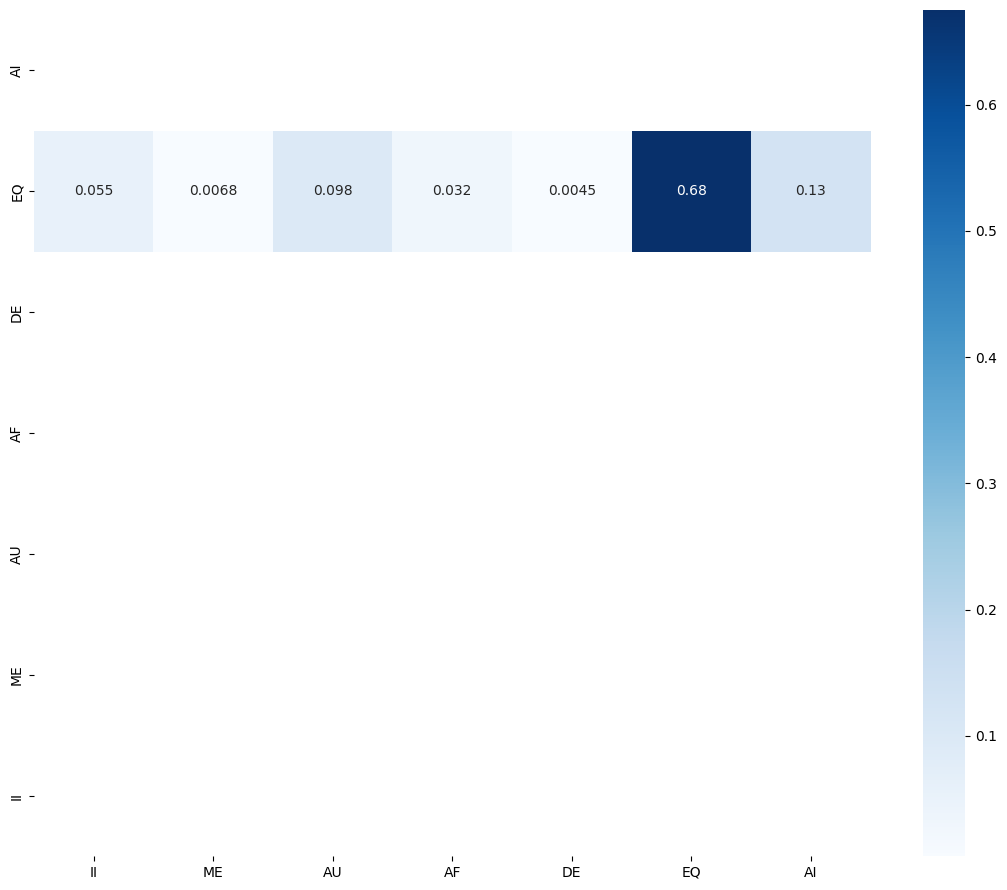

In [18]:
for index, category in enumerate(heat_map):
    total = 0
    for val in category:
        total = total + val
    for index_2, val in enumerate(category):
        heat_map[index][index_2] = val / total

fig, ax = plt.subplots(figsize=(11,9))
fig.set_tight_layout(True)
# color map
labels = ['II','ME','AU','AF','DE','EQ','AI']
y_labels = ['AI','EQ','DE','AF','AU','ME','II']

sns.heatmap(heat_map,cmap="Blues",xticklabels=labels, yticklabels=y_labels, annot=True)


In [19]:
actual = final_val["label"].tolist()
predicted = preds
live.log_sklearn_plot("confusion_matrix", actual, predicted)